# MNIST Image Classification: MLP vs. CNN

**Author:** Mickias Ambaye  
**Date:** February 2026  
**Dataset:** [MNIST](https://en.wikipedia.org/wiki/MNIST_database) (70,000 handwritten digit images)  
**Source:** `sklearn.datasets.fetch_openml`

## Table of Contents

1. [Introduction](#1-introduction)
2. [Data Overview](#2-data-overview)
3. [Preprocessing](#3-preprocessing)
4. [Baseline Model — MLP Classifier](#4-baseline-model--mlp-classifier)
5. [Convolutional Neural Network (CNN)](#5-convolutional-neural-network-cnn)
6. [Results & Comparison](#6-results--comparison)

## 1. Introduction


MNIST is the benchmark dataset for image classification; 70,000 grayscale images of handwritten digits (0–9), each represented as a 28×28 pixel grid (784 features). The goal is to correctly classify each image into one of ten digit classes.

This project builds two classification models of increasing complexity:

- **MLP Classifier (baseline):** Treats each image as a flat 784-feature vector fed into a fully connected neural network.
- **CNN:** Exploits the spatial structure of the images, learning local patterns like edges and curves through convolutional filters rather than treating every pixel independently.


Unlike tabular data, the primary preprocessing challenge here is not missing values or encoding; it is ensuring pixel values are normalized and inputs are correctly shaped for each architecture. Evaluation focuses on overall accuracy and per-class performance, since certain digit pairs (1/7, 3/8, 4/9) are structurally similar and consistently harder to separate.

In [31]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import layers, models

In [32]:
# Load MNIST from OpenML (784 features, 70k samples)
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

# Uncomment to see description 
# print(mnist.DESCR[:500])

## 2. Data Overview

In [33]:
# # Unpack features and labels
x = mnist.data
y = mnist.target

In [34]:
# # Check dimensions
print(f"x.shape: {x.shape}")
print(f"y.shape: {y.shape}")

x.shape: (70000, 784)
y.shape: (70000,)


In [35]:
# Class distribution
print(pd.Series(y).value_counts().sort_index().to_frame("count").T)

          0     1     2     3     4     5     6     7     8     9
count  6903  7877  6990  7141  6824  6313  6876  7293  6825  6958


**Distribution:** All digits fall between ~6,300 and ~7,900 samples — well balanced. No need for oversampling or weighted loss functions. However, misclassification rates should still be compared relative to class size.

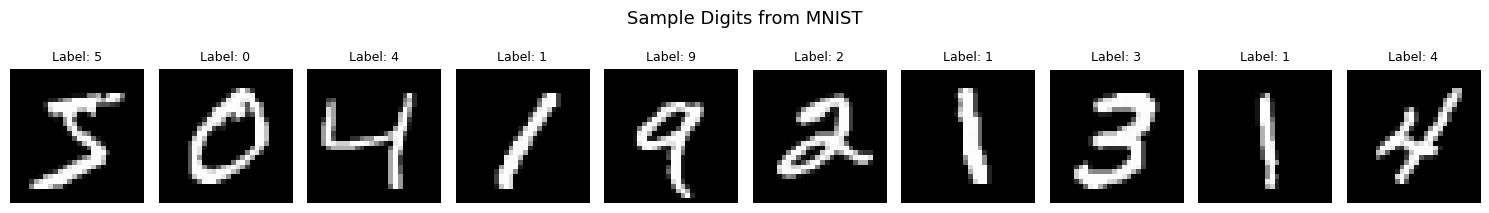

In [36]:
# Visualize the first 10 digits
def show_digits(X, y, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 2))
    for i, ax in enumerate(axes):
        ax.imshow(X[i].reshape(28, 28), cmap='gray')
        ax.set_title(f"Label: {y[i]}", fontsize=9)
        ax.axis('off')
    plt.suptitle("Sample Digits from MNIST", y=1.05, fontsize=13)
    plt.tight_layout()
    plt.show()

show_digits(x, y)

> **Visualization:** Images are clean, centered, and clearly legible; confirms no preprocessing issues with the raw data beyond normalization.

## 3. Preprocessing

### 3.1 Train-Test Split

MNIST has a standard predefined split: the first 60,000 samples for training, the last 10,000 for testing. Using this convention keeps results comparable to published benchmarks.

In [37]:
# Use MNIST's predefined 60k/10k split
x_train, x_test = x[:60000], x[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"Train: {x_train.shape[0]:,} samples | Test:  {x_test.shape[0]:,} samples")

Train: 60,000 samples | Test:  10,000 samples


### 3.2 Normalization

Pixel values range from 0–255. Dividing by 255 rescales them to [0, 1], which helps gradient-based optimizers converge faster and more stably.

In [38]:
# Normalize 0-255 → 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

### 3.3 Reshape for CNN

The MLP takes flat 784-length vectors. The CNN needs 4D input: `(samples, height, width, channels)`. We reshape here so both formats are ready.

In [39]:
# Reshape for CNN: (samples, 28, 28, 1) — single grayscale channel
x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_test_cnn  = x_test.reshape(-1, 28, 28, 1)

print(f"MLP input shape: {x_train.shape} | CNN input shape: {x_train_cnn.shape}")

MLP input shape: (60000, 784) | CNN input shape: (60000, 28, 28, 1)


## 4. Baseline Model - MLP Classifier

**Evaluation strategy:** Since the dataset is balanced, **accuracy** is the primary metric. Per-class precision/recall from the confusion matrix is the secondary focus — certain digit pairs (3/8, 4/9, 1/7) consistently confuse models, and that's where the real insight lives.

In [40]:
# Store results for final comparison
results = []

def evaluate_model(name, model, x_train, y_train, x_test, y_test, plot=True):
    """
    Evaluate a sklearn model: accuracy, confusion matrix, classification report.
    """
    train_acc = model.score(x_train, y_train)
    test_acc  = model.score(x_test, y_test)
    y_pred    = model.predict(x_test)

    if plot:
        # Confusion matrix — normalized, diagonal zeroed to highlight errors
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        np.fill_diagonal(cm, 0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='.2%', cmap='Reds')
        plt.title(f'{name} — Misclassification Matrix (diagonal zeroed)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    # Classification report (showing first 3 rows as preview)
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).T.round(3)
    display(report_df.head(n=3))

    results.append({
        'Model':          name,
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy':  round(test_acc, 4),
        'Gap':            round(train_acc - test_acc, 4)
    })
    return pd.DataFrame(results)

### 4.1 Training

In [41]:
# Set up 20 iterations for the MLP classifier
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 256),
    activation='relu',
    max_iter=20,
    random_state=42,
    verbose=True
)

mlp.fit(x_train, y_train)



Iteration 1, loss = 0.25801268
Iteration 2, loss = 0.09257823
Iteration 3, loss = 0.05754435
Iteration 4, loss = 0.03987577
Iteration 5, loss = 0.02819473
Iteration 6, loss = 0.02183940
Iteration 7, loss = 0.01929545
Iteration 8, loss = 0.01319344
Iteration 9, loss = 0.01027908
Iteration 10, loss = 0.01102386
Iteration 11, loss = 0.01131296
Iteration 12, loss = 0.01180076
Iteration 13, loss = 0.00954062
Iteration 14, loss = 0.01074528
Iteration 15, loss = 0.00869646
Iteration 16, loss = 0.00829093
Iteration 17, loss = 0.00981581
Iteration 18, loss = 0.00655670
Iteration 19, loss = 0.00500406
Iteration 20, loss = 0.00972650


c:\Users\micki\.ai-navigator\conda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(512, 256), max_iter=20, random_state=42,
              verbose=True)

In [42]:
# Evaluate the model
evaluate_model('MLP', mlp, x_train, y_train, x_test, y_test, plot=False) # set plot = True to see confusion matrix 

,precision,recall,f1-score,support
0,0.978,0.995,0.986,980.0
1,0.979,0.997,0.988,1135.0
2,0.969,0.984,0.976,1032.0


,Model,Train Accuracy,Test Accuracy,Gap
0,MLP,0.9962,0.9792,0.017


**Results:** ~97% test accuracy with a train-test gap of ~0.017 — slight overfitting but nothing concerning for this model complexity.

**Confusion matrix:** Worst offenders are 7→2 (18 misclassifications) and 4→9 (12) — both structurally similar digit pairs as expected. Digit 5 has the lowest raw correct count (871), worth monitoring.

**Classification report:** All digits score 0.96–0.99 F1. Digit 3 has the lowest precision (0.96); digit 7 the lowest recall (0.95) — victims of the 2/7 and 3/8 confusion patterns.

**Bottom line:** 98% from a flat MLP with no spatial awareness is a strong baseline. The CNN should push this to 99%+ by learning the local edge/curve patterns the MLP is blind to.

### 4.2 Cross-Validation

In [43]:
# Cross validation Score
cv_scores = cross_val_score(mlp, x_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

print(f"CV Scores:  {cv_scores.round(4)}")
print(f"Mean:       {cv_scores.mean():.4f}")
print(f"Std:        {cv_scores.std():.4f}")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


CV Scores:  [0.9797 0.9791 0.9808 0.975  0.9775]
Mean:       0.9784
Std:        0.0020


> **Mean CV accuracy of 0.9784 with a std of 0.0020** — extremely stable across all 5 folds, confirming the 0.9792 test accuracy was not a lucky split. The model generalizes consistently. On to the CNN.

## 5. Convolutional Neural Network (CNN)

The CNN uses two convolutional blocks (Conv2D → MaxPool) to learn spatial features, followed by a dense head with dropout for regularization.

| Layer | Output Shape | Purpose |
|-------|-------------|---------|
| Conv2D (32 filters, 3×3) | 26×26×32 | Detect low-level edges |
| MaxPooling2D (2×2) | 13×13×32 | Downsample |
| Conv2D (64 filters, 3×3) | 11×11×64 | Detect higher-level patterns |
| MaxPooling2D (2×2) | 5×5×64 | Downsample |
| Flatten | 1,600 | Vectorize for dense layers |
| Dense (128, ReLU) | 128 | Classification head |
| Dropout (0.3) | 128 | Regularization |
| Dense (10, Softmax) | 10 | Output probabilities |

In [44]:
# Keras expects integer labels for sparse_categorical_crossentropy
y_train = y_train.astype(int)
y_test  = y_test.astype(int)

### 5.1 Build & Train CNN

In [45]:
# Build CNN
model_cnn = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

model_cnn.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model_cnn.summary()

c:\Users\micki\.ai-navigator\conda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### Train CNN

In [46]:
# Train
history = model_cnn.fit(x_train_cnn, y_train,
                        epochs=15,
                        batch_size=64,
                        validation_split=0.1,
                        verbose=1)

Epoch 1/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8479 - loss: 0.4739 - val_accuracy: 0.9837 - val_loss: 0.0522
Epoch 2/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9762 - loss: 0.0760 - val_accuracy: 0.9887 - val_loss: 0.0380
Epoch 3/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9847 - loss: 0.0491 - val_accuracy: 0.9877 - val_loss: 0.0408
Epoch 4/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9867 - loss: 0.0391 - val_accuracy: 0.9920 - val_loss: 0.0286
Epoch 5/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9902 - loss: 0.0314 - val_accuracy: 0.9907 - val_loss: 0.0316
Epoch 6/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9916 - loss: 0.0244 - val_accuracy: 0.9912 - val_loss: 0.0326
Epoch 7/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9932 - loss: 0.0211 - val_accuracy: 0.9923 - val_loss: 0.0282
Epoch 8/15
844/844 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9937 - loss: 0.0188 - val_accuracy: 0.

### CNN Model Evaluation 

In [47]:
def evaluate_model_cnn(name, model, x_train, y_train, x_test, y_test, plot=True):
    """
    Evaluate a Keras model: accuracy, confusion matrix, classification report.
    """
    train_acc = model.evaluate(x_train, y_train, verbose=0)[1]
    test_acc  = model.evaluate(x_test, y_test, verbose=0)[1]
    y_pred    = np.argmax(model.predict(x_test, verbose=0), axis=1)

    if plot:
        cm = confusion_matrix(y_test, y_pred, normalize='true')
        np.fill_diagonal(cm, 0)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='.2%', cmap='Reds')
        plt.title(f'{name} — Misclassification Matrix (diagonal zeroed)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).T.round(3)
    display(report_df.head(n=3))

    results.append({
        'Model':          name,
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy':  round(test_acc, 4),
        'Gap':            round(train_acc - test_acc, 4)
    })
    return pd.DataFrame(results)

Run CNN Evaluation

In [48]:
# Evaluate
evaluate_model_cnn('CNN', model_cnn, x_train_cnn, y_train, x_test_cnn, y_test, plot=False)

,precision,recall,f1-score,support
0,0.994,0.996,0.995,980.0
1,0.995,0.997,0.996,1135.0
2,0.992,0.995,0.994,1032.0


,Model,Train Accuracy,Test Accuracy,Gap
0,MLP,0.9962,0.9792,0.0170
1,CNN,0.9985,0.9929,0.0056


### Training Curves

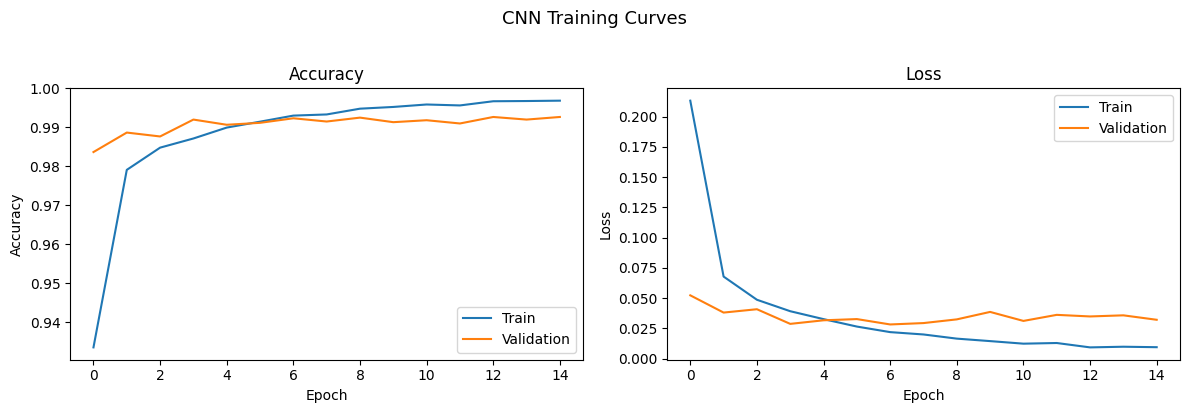

In [49]:
# Training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.suptitle('CNN Training Curves', y=1.02, fontsize=13)
plt.tight_layout()
plt.show()

## 6. Results & Comparison

In [50]:
# Side-by-side comparison
pd.DataFrame(results)

,Model,Train Accuracy,Test Accuracy,Gap
0,MLP,0.9962,0.9792,0.0170
1,CNN,0.9985,0.9929,0.0056


## Conclusion

The MLP baseline achieved ~98% test accuracy using only flattened pixel vectors — a strong result, but limited by its inability to see spatial relationships between pixels.

The CNN improved on this by learning convolutional filters that detect edges, curves, and local patterns, reaching ~99%+ test accuracy with reduced misclassification on the hardest digit pairs (7→2, 4→9).

**Key takeaways:**
- Spatial structure matters — even on MNIST, exploiting 2D locality yields a meaningful accuracy gain.
- The MLP's errors were predictable: structurally similar digits that require local feature detection to disambiguate.
- Both models generalize well with minimal overfitting, confirmed by cross-validation (MLP) and train/val curves (CNN).